In [1]:
import random
random.seed(12345678)

In [2]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from functools import partial
import pandas as pd
import geopandas as gpd
import csv
import os
import datetime  #For keeping track of runtime
import tqdm # for progress bar

In [3]:
beginrun = datetime.datetime.now()
print ("\nBegin date and time : ", beginrun.strftime("%Y-%m-%d %H:%M:%S"))


Begin date and time :  2025-04-30 19:19:57


In [4]:
outdir="./NM_recom_SOS18/"

In [ ]:
total_steps_in_run=1000000 
save_district_graph_mod=25000
save_district_plot_mod=100000

In [6]:
os.makedirs(outdir, exist_ok=True)
graph = Graph.from_file("NM/NM.shp")


In [7]:
elections = [
    Election("USS18", {"Democratic": "G18USSD", "Republican": "G18USSR"}),
    Election("GOV18", {"Democratic": "G18GOVD", "Republican": "G18GOVR"}),
    Election("SOS18", {"Democratic": "G18SOSD", "Republican": "G18SOSR"}),
    Election("TRE18", {"Democratic": "G18TRED", "Republican": "G18TRER"}),
    Election("ATG18", {"Democratic": "G18ATGD", "Republican": "G18ATGR"}),
    Election("AUD18", {"Democratic": "G18AUDD", "Republican": "G18AUDR"}),
    Election("LND18", {"Democratic": "G18LNDD", "Republican": "G18LNDR"}),
]
sample_node = next(iter(graph.nodes(data=True)))
print(sample_node[1].keys())



dict_keys(['boundary_node', 'area', 'STATEFP', 'COUNTYFP', 'COUNTYNAME', 'VTDST', 'NAME', 'G20PRED', 'G20PRER', 'G20SACDIVE', 'G20SACRJOH', 'G20SACDHEN', 'G20SACRLEE', 'G20SACLCUR', 'G20SACDYOH', 'G20SACRMON', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'G18USSD', 'G18USSR', 'G18GOVD', 'G18GOVR', 'G18SOSD', 'G18SOSR', 'G18TRED', 'G18TRER', 'G18ATGD', 'G18ATGR', 'G18AUDD', 'G18AUDR', 'G18LNDD', 'G18LNDR', 'SACD', 'geometry'])


In [8]:
my_updaters = {"population": updaters.Tally("TOTPOP", alias="population")}

In [9]:
for _, data in graph.nodes(data=True):
    print(data.keys())
    break

election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

dict_keys(['boundary_node', 'area', 'STATEFP', 'COUNTYFP', 'COUNTYNAME', 'VTDST', 'NAME', 'G20PRED', 'G20PRER', 'G20SACDIVE', 'G20SACRJOH', 'G20SACDHEN', 'G20SACRLEE', 'G20SACLCUR', 'G20SACDYOH', 'G20SACRMON', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'G18USSD', 'G18USSR', 'G18GOVD', 'G18GOVR', 'G18SOSD', 'G18SOSR', 'G18TRED', 'G18TRER', 'G18ATGD', 'G18ATGR', 'G18AUDD', 'G18AUDR', 'G18LNDD', 'G18LNDR', 'SACD', 'geometry'])


In [10]:
initial_partition = GeographicPartition(graph, 
                                        assignment= "SACD", #"2011_PLA_1",     # "GOV", "REMEDIAL_P", 
                                        updaters=my_updaters)

In [11]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

In [12]:
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.1,
                   node_repeats=3
                  )

In [13]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

In [14]:
pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.15)

In [15]:
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=total_steps_in_run
    )



In [16]:
data = pd.DataFrame(
    sorted(partition["SOS18"].percents("Democratic"))
    for partition in chain.with_progress_bar()
)

c:\Users\fortn\anaconda3\envs\gerry\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  1%|          | 8124/1000000 [02:07<4:19:01, 63.82it/s] c:\Users\fortn\anaconda3\envs\gerry\Lib\site-packages\gerrychain\tree.py:704: BipartitionWarning: 
Failed to find a balanced cut after 1000 attempts.
If possible, consider enabling pair reselection within your
MarkovChain proposal method to allow the algorithm to select
a different pair of districts for recombination.
  warnings.warn(
100%|██████████| 1000000/1000000 [15:59:55<00:00, 17.36it/s]       


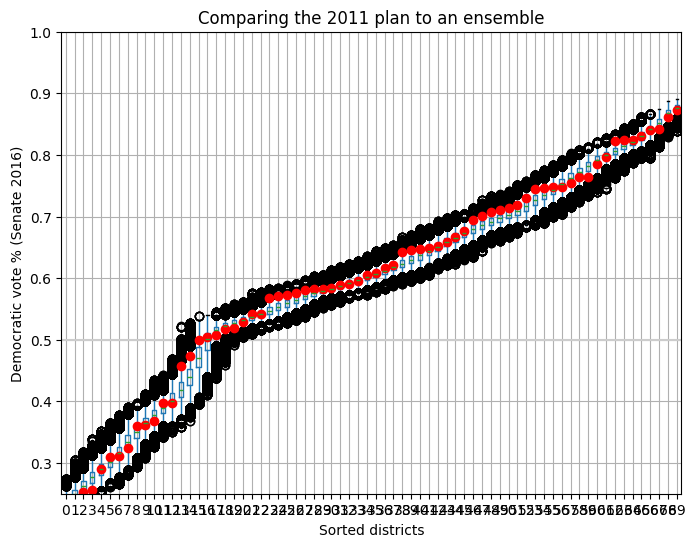

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row, which corresponds to the initial plan)
plt.plot(data.iloc[0], "ro")

# Annotate
ax.set_title("Comparing the 2011 plan to an ensemble")
ax.set_ylabel("Democratic vote % (Senate 2016)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0.25, 1)
ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.savefig('PAbox_plotSen2016.png')
plt.show()

In [18]:
df=gpd.read_file("NM/NM.shp")

In [19]:
index_output_file = outdir + "_index.csv"

In [20]:
with open(index_output_file, mode='w') as index_file:
    index_writer = csv.writer(index_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    #Run through chain, building 
    for t, part in enumerate(chain):
        if t%save_district_graph_mod==0:
            tmp_str=str(t)
            file_prefix=tmp_str.rjust(8,'0')
            
            #Add file names to index file            
            edges_output_file = outdir + file_prefix + "_edges.csv"
            districts_output_file = outdir + file_prefix + "_districts.csv"            
            index_writer.writerow(["./" + file_prefix + "_districts.csv", "./" + file_prefix + "_edges.csv"])
                        

            #Build the district graph and write edges to file    
            s=set()
            for e in part["cut_edges"]:
                s.add( (part.assignment[e[0]],part.assignment[e[1]] ))
                #s.add( (e[0],e[1]) )
                
            with open(edges_output_file, mode='w') as edges_file:
                edges_writer = csv.writer(edges_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        
                for e1 in s:
                    edges_writer.writerow([e1[0],e1[1]])
               
            
            #Build the district file that contains election results
            D_votes = part["SOS18"].votes("Democratic") 
            R_votes = part["SOS18"].votes("Republican") 
           
            with open(districts_output_file, mode='w') as districts_file:            
                districts_writer = csv.writer(districts_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        
                for i in range(len(D_votes)):
                    districts_writer.writerow([i+1, int(D_votes[i]),int(R_votes[i]),0])
             
        if t%save_district_plot_mod==0:
            df.plot(pd.Series([part.assignment[i] for i in df.index]), cmap="tab20", figsize=(16,8))
            #plt.show()
            plot_output_file = outdir + file_prefix + "_plot.png"
            plt.savefig(plot_output_file)
            plt.close()
    
            

c:\Users\fortn\anaconda3\envs\gerry\Lib\site-packages\gerrychain\tree.py:704: BipartitionWarning: 
Failed to find a balanced cut after 1000 attempts.
If possible, consider enabling pair reselection within your
MarkovChain proposal method to allow the algorithm to select
a different pair of districts for recombination.
  warnings.warn(
c:\Users\fortn\anaconda3\envs\gerry\Lib\site-packages\gerrychain\tree.py:704: BipartitionWarning: 
Failed to find a balanced cut after 1000 attempts.
If possible, consider enabling pair reselection within your
MarkovChain proposal method to allow the algorithm to select
a different pair of districts for recombination.
  warnings.warn(
c:\Users\fortn\anaconda3\envs\gerry\Lib\site-packages\gerrychain\tree.py:704: BipartitionWarning: 
Failed to find a balanced cut after 1000 attempts.
If possible, consider enabling pair reselection within your
MarkovChain proposal method to allow the algorithm to select
a different pair of districts for recombination.
  warn

And if you want to find the total time:

In [21]:
endrun = datetime.datetime.now()
print ("\nEnd date and time : ", endrun.strftime("%Y-%m-%d %H:%M:%S"))

    
diff=endrun-beginrun
print("\nTotal time: ", str(diff))


End date and time :  2025-05-01 18:06:03

Total time:  22:46:06.656678
